In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE16512"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Lodes2009", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [4]:
table

,0,1,2,3,4,5,6,7,8,9,...,538,539,540,541,542,543,544,545,546,547
VALUE,0.078054,1.171537,0.433468,0.013670,-0.187630,-0.555557,0.545214,2.869191,0.887582,-0.288391,...,0.000000,7.953153,-0.392408,-0.144915,0.000000,-0.308567,0.000000,2.087868,0.993887,0.000000
VALUE,0.340217,0.000000,0.000000,0.150862,-0.173327,0.000000,0.000000,0.388173,0.046117,0.083408,...,-0.200684,0.205599,1.688097,0.432885,0.744402,0.351123,0.409733,0.000000,1.464288,1.881555
VALUE,-0.343142,0.680074,-0.164399,-0.067362,0.558346,-0.564484,-0.220133,-0.156521,0.019241,-0.098076,...,-0.568990,8.412090,-0.272823,0.428268,0.000000,-0.224154,-0.372579,1.426798,0.441208,0.000000
VALUE,-0.192766,1.263682,0.069909,-0.105602,0.391736,-0.365426,0.038682,0.000000,-0.691109,-0.308318,...,-0.218098,9.004395,-0.235094,0.180698,0.127676,0.131492,-0.464373,1.195263,0.468392,1.788591
VALUE,0.097322,0.960174,-0.049996,-0.196522,0.973474,-0.383603,-0.072233,-0.150931,0.276285,0.037879,...,0.064995,9.264560,-0.049996,0.741902,0.224377,0.398497,0.129421,1.095764,0.000000,1.483774
VALUE,0.012219,0.725685,0.000000,-0.587738,0.722712,0.000000,-0.260994,-0.159841,-0.182924,-0.443336,...,-0.574752,11.797474,-0.609488,0.444085,0.120013,0.309355,0.000000,1.582841,0.000000,1.249040
VALUE,0.244136,1.546283,0.308648,0.465865,0.253908,-0.447166,0.183827,2.334271,0.846051,-0.376370,...,-0.582915,4.831622,0.270825,-0.309402,0.685177,-0.392668,-0.400897,2.698396,0.648566,1.500000
VALUE,0.000000,0.224059,0.000000,0.000000,0.185553,-0.986832,-0.459599,0.332207,0.316595,-0.289692,...,-0.164939,0.367594,0.932997,0.162470,0.476906,0.394232,0.693410,0.773945,1.778494,0.000000
VALUE,-0.069761,1.070858,0.041274,0.385720,-0.196247,-0.610765,-0.115514,2.304144,0.455439,-0.707968,...,0.000000,3.793899,0.649376,0.000000,0.000000,-0.360089,0.178563,1.938612,1.973173,1.281742
VALUE,0.486317,1.315384,0.568743,0.500451,0.101129,-0.388852,0.981028,2.388396,0.881702,-0.421555,...,0.000000,4.971973,0.883750,-0.317663,0.868303,-0.421555,-0.325987,2.378338,1.083261,1.488504


### Seperate case and controls

In [5]:
set([k.metadata["title"][0] for k in list(data.gsms.values())[:-1]])

{'Bre-157-4|32',
 'Bre-158-4|11',
 'Col-120-3|36',
 'Col-121-1|37',
 'Col-122-2|38',
 'Col-123-2|39',
 'Col-792-2|18',
 'Col-796-3|10',
 'Col-798-3|19',
 'Col-92-2|14',
 'Col-98-3|15',
 'Nor-23-0|20',
 'Nor-27-0|21',
 'Nor-28-0|22',
 'Nor-31-0|47',
 'Nor-32-0|46',
 'Nor-47-0|45',
 'Nor-48-0|44',
 'Nor-F4567-0|04',
 'Nor-F4567-0|05',
 'Nor-F4567-0|06',
 'Nor-F4567-0|07',
 'Nor-M-0|28',
 'Nor-M24-0|26',
 'Nor-M28-0|24',
 'Ova-781-4|34',
 'Ova-782-4|09',
 'Pros-11-3|12',
 'Pros-14-3|13',
 'Pros-808-4|00',
 'Pros-809-4|30',
 'Pros-812-3|08',
 'Pros-814-3|17',
 'lun-151-4|02',
 'lun-153-3|35'}

In [54]:
sick = np.array(["lung" in k.metadata["title"][0] for k in list(data.gsms.values())[:-1]])
controls = 1 - sick

In [55]:
sum(controls)

32

### Drop NAN

In [56]:
table = table.dropna(1)

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_15984/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [57]:
X = table

In [58]:
X

,2,10,11,18,30,39,59,60,64,69,...,178,184,185,219,249,254,258,265,268,271
VALUE,-6.007,-6.269,-3.394,-4.252,-5.704,-0.281,-5.917,-3.155,-4.338,-7.009,...,-3.542,-0.694,-4.444,-1.697,-4.303,0.721,-5.445,-3.313,-7.001,-4.471
VALUE,-5.546,-7.171,-4.306,-4.407,-6.074,-3.329,-6.721,-4.099,-4.414,-9.458,...,-3.834,-0.772,-6.416,-2.568,-6.947,-1.795,-6.064,-3.245,-8.424,-4.245
VALUE,-5.825,-6.832,-3.880,-3.667,-6.411,-1.953,-7.486,-4.372,-2.949,-8.878,...,-4.020,-1.554,-6.635,-3.155,-6.047,-2.026,-5.632,-3.790,-7.345,-4.186
VALUE,-4.751,-5.800,-3.065,-5.036,-6.519,-4.274,-6.546,-3.564,-4.852,-7.689,...,-3.550,-1.452,-6.361,-3.068,-7.193,-3.015,-5.687,-2.469,-6.438,-3.456
VALUE,-4.889,-6.665,-3.661,-5.448,-7.186,-3.958,-7.816,-4.531,-5.607,-9.386,...,-3.504,-2.502,-6.605,-2.620,-6.790,-4.337,-6.467,-3.431,-7.687,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-2.328,-5.728,-3.298,0.915,-6.170,-2.048,-5.893,-2.331,-4.585,-8.169,...,-2.725,0.343,-6.159,-0.498,-5.286,4.769,-5.469,-1.365,-7.083,-2.358
VALUE,-4.278,-5.166,-1.666,-3.302,-6.275,-1.293,-6.354,-3.376,-3.322,-7.803,...,-1.682,-1.786,-4.839,-0.675,-5.652,-1.139,-5.473,-0.157,-6.153,-1.675
VALUE,-4.457,-6.092,-2.179,-2.231,-6.805,-3.402,-6.905,-3.813,-5.146,-8.163,...,-2.369,-0.752,-6.647,-2.102,-7.207,-1.570,-5.333,-1.339,-5.837,-2.335
VALUE,-2.641,-5.226,-2.353,-3.198,-6.253,-3.560,-6.731,-2.973,-3.655,-9.432,...,-3.004,-2.616,-7.103,-1.118,-6.644,-3.444,-7.019,-0.870,-7.227,-2.072


In [59]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [60]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [61]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [62]:
mirnas.iloc[lowest], pvalues

(17    hsa-miR-1208-002880
 28    hsa-miR-125b-000449
 35    hsa-miR-1275-002840
 31     hsa-miR-127-000452
 37    hsa-miR-1285-002822
 Name: ID_REF, dtype: object,
 array([3.76096963e-11, 2.11681487e-10, 1.38729590e-06, 2.14211922e-05,
        7.60508932e-05]))

### F-test

In [63]:
t3 = table

In [64]:
f, p = f_classif(t3, sick)

In [65]:
np.mean(p)

0.1988222127765461

### ANOVA

In [66]:
t3

,2,10,11,18,30,39,59,60,64,69,...,178,184,185,219,249,254,258,265,268,271
VALUE,-6.007,-6.269,-3.394,-4.252,-5.704,-0.281,-5.917,-3.155,-4.338,-7.009,...,-3.542,-0.694,-4.444,-1.697,-4.303,0.721,-5.445,-3.313,-7.001,-4.471
VALUE,-5.546,-7.171,-4.306,-4.407,-6.074,-3.329,-6.721,-4.099,-4.414,-9.458,...,-3.834,-0.772,-6.416,-2.568,-6.947,-1.795,-6.064,-3.245,-8.424,-4.245
VALUE,-5.825,-6.832,-3.880,-3.667,-6.411,-1.953,-7.486,-4.372,-2.949,-8.878,...,-4.020,-1.554,-6.635,-3.155,-6.047,-2.026,-5.632,-3.790,-7.345,-4.186
VALUE,-4.751,-5.800,-3.065,-5.036,-6.519,-4.274,-6.546,-3.564,-4.852,-7.689,...,-3.550,-1.452,-6.361,-3.068,-7.193,-3.015,-5.687,-2.469,-6.438,-3.456
VALUE,-4.889,-6.665,-3.661,-5.448,-7.186,-3.958,-7.816,-4.531,-5.607,-9.386,...,-3.504,-2.502,-6.605,-2.620,-6.790,-4.337,-6.467,-3.431,-7.687,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-2.328,-5.728,-3.298,0.915,-6.170,-2.048,-5.893,-2.331,-4.585,-8.169,...,-2.725,0.343,-6.159,-0.498,-5.286,4.769,-5.469,-1.365,-7.083,-2.358
VALUE,-4.278,-5.166,-1.666,-3.302,-6.275,-1.293,-6.354,-3.376,-3.322,-7.803,...,-1.682,-1.786,-4.839,-0.675,-5.652,-1.139,-5.473,-0.157,-6.153,-1.675
VALUE,-4.457,-6.092,-2.179,-2.231,-6.805,-3.402,-6.905,-3.813,-5.146,-8.163,...,-2.369,-0.752,-6.647,-2.102,-7.207,-1.570,-5.333,-1.339,-5.837,-2.335
VALUE,-2.641,-5.226,-2.353,-3.198,-6.253,-3.560,-6.731,-2.973,-3.655,-9.432,...,-3.004,-2.616,-7.103,-1.118,-6.644,-3.444,-7.019,-0.870,-7.227,-2.072


In [67]:
X = np.array(sick).reshape(-1, 1)

In [68]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [69]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.09563329315397899

### Mean-variance-plot

In [70]:
table = table.iloc[:, 1:]

In [71]:
np.mean(table)

10     -6.359500
11     -3.484743
18     -4.213957
30     -6.532257
39     -2.504714
59     -6.396157
60     -3.754700
64     -5.565743
69     -8.189500
70     -6.705671
72     -1.302343
86     -3.997014
88     -3.017771
89     -4.887686
90     -9.259586
99     -6.142629
100    -4.147700
102    -6.017057
110    -5.353657
111   -11.132357
114    -7.341529
115    -3.177800
130    -5.648286
131    -3.830500
132    -4.513957
134    -2.635386
153    -4.353386
178    -4.329643
184    -1.088414
185    -6.632286
219    -2.596857
249    -6.644914
254    -2.525600
258    -5.977129
265    -1.155957
268    -7.413629
271    -3.704814
dtype: float64

In [72]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table)

In [73]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

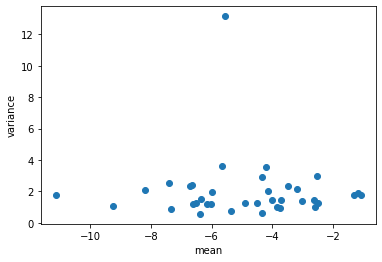

In [74]:
mean_variance_plot(table)

### Loess regression

In [170]:
lowess = LowessRegression(sigma=1, span=0.1)

In [171]:
means, variances = get_means_and_variances(table)
st_devs = np.sqrt(variances)
lowess.fit(means.to_numpy().reshape(-1,1), st_devs)

LowessRegression(span=0.1)

In [172]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

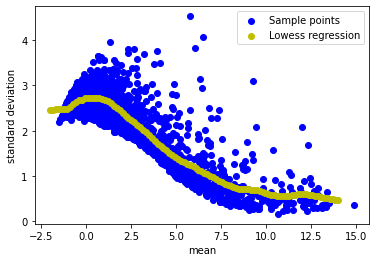

In [173]:
plt.scatter(means, st_devs, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("standard deviation")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [174]:
adj_std_devs = lowess.predict(means.to_numpy().reshape(-1, 1))

In [175]:
table /= adj_std_devs

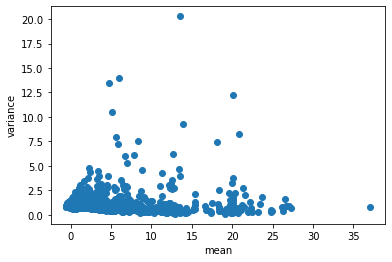

In [176]:
mean_variance_plot(table)

### Log transformation

In [75]:
log_table = table #np.log2(table)

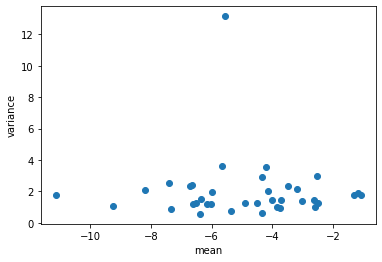

In [76]:
mean_variance_plot(log_table)

In [77]:
norm_log_table = log_table - np.mean(log_table)

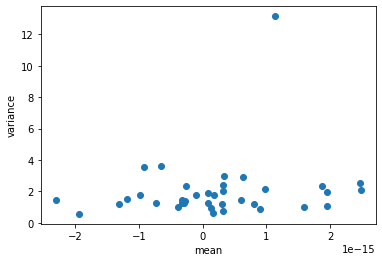

In [78]:
mean_variance_plot(norm_log_table)

### PCA

In [79]:
pca = decomposition.PCA(n_components=10)

In [80]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [81]:
pca.explained_variance_ratio_

array([0.4614339 , 0.15804639, 0.08607672, 0.07314251, 0.03411063,
       0.03154819, 0.02879219, 0.02382715, 0.01792494, 0.01380757])

In [82]:
components = pca.transform(norm_log_table)

In [83]:
components.shape

(70, 10)

In [84]:
sum(controls)

32

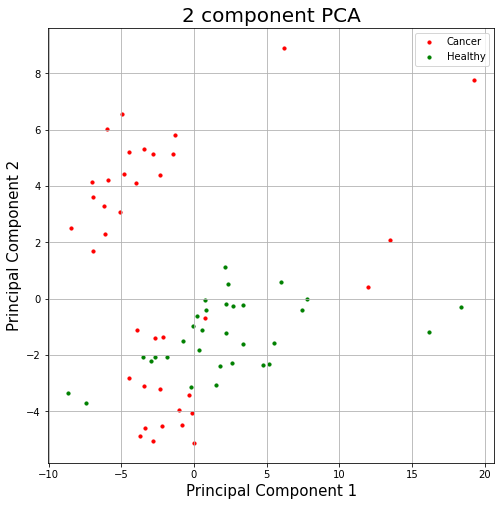

In [87]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [88]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

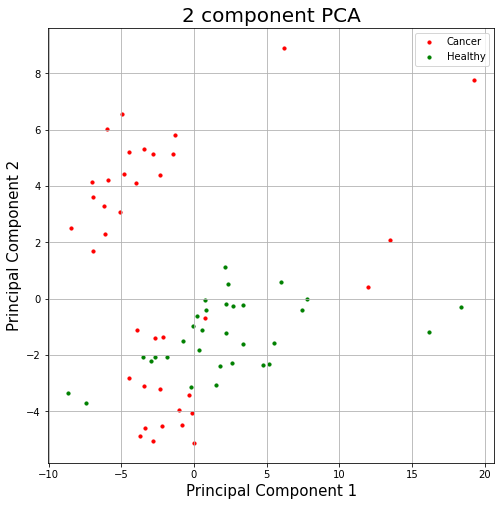

In [89]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [90]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [91]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

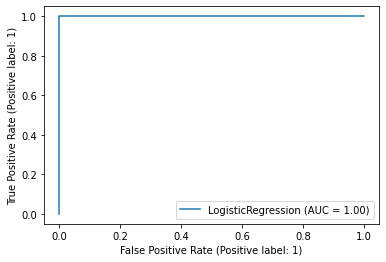

In [92]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [93]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[13:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

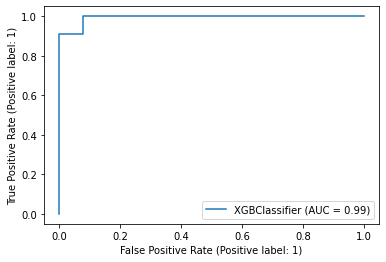

In [94]:
plot_roc_curve(model, X_test, y_test)